![image info](https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/images/banner_1.png)

# Proyecto 1 - Predicción de precios de vehículos usados

En este proyecto podrán poner en práctica sus conocimientos sobre modelos predictivos basados en árboles y ensambles, y sobre la disponibilización de modelos. Para su desarrollo tengan en cuenta las instrucciones dadas en la "Guía del proyecto 1: Predicción de precios de vehículos usados".

**Entrega**: La entrega del proyecto deberán realizarla durante la semana 4. Sin embargo, es importante que avancen en la semana 3 en el modelado del problema y en parte del informe, tal y como se les indicó en la guía.

Para hacer la entrega, deberán adjuntar el informe autocontenido en PDF a la actividad de entrega del proyecto que encontrarán en la semana 4, y subir el archivo de predicciones a la [competencia de Kaggle](https://www.kaggle.com/competitions/miad2024-12-prediccion-precio-vehiculos).

# Procesamiento y exploración preliminar de datos

In [1]:
# librerías
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [2]:
# cargar datos (se tiene en .csv en local)
df_train=pd.read_csv("dataTrain_carListings.csv")
# data test tiene una columna llamada ID, que solamente es el orden de numeros
df_test=pd.read_csv("dataTest_carListings.csv", index_col=0)
# Cargar datos reales
# df_real=pd.read_csv("true_car_listings.csv")

In [3]:
# eliminar columnas adicionales
# df_real.drop(["City", "Vin"], axis=1, inplace=True)
# df_real.columns

Index(['Price', 'Year', 'Mileage', 'State', 'Make', 'Model'], dtype='object')

## Entrenamiento y calibración de XGB

In [4]:
# pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
import sklearn.datasets
import sklearn.metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import XGBRegressor

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   Price    400000 non-null  int64 
 1   Year     400000 non-null  int64 
 2   Mileage  400000 non-null  int64 
 3   State    400000 non-null  object
 4   Make     400000 non-null  object
 5   Model    400000 non-null  object
dtypes: int64(3), object(3)
memory usage: 18.3+ MB


In [5]:
# Codificar variables categóricas
categorical_columns = ['State', 'Make', 'Model']
df_train = pd.get_dummies(df_train, columns=categorical_columns).astype(int)

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
data = df_train.drop(['Price'], axis=1)
target = df_train['Price']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.25, random_state=42)

# Convertir los arrays resultantes en DataFrames de pandas
X_train = pd.DataFrame(X_train, columns=data.columns)
X_test = pd.DataFrame(X_test, columns=data.columns)
y_train = pd.Series(y_train, name='Price')
y_test = pd.Series(y_test, name='Price')

# Verifica los tipos de datos de las estructuras resultantes
print("Tipo de X_train:", type(X_train))
print("Tipo de X_test:", type(X_test))
print("Tipo de y_train:", type(y_train))
print("Tipo de y_test:", type(y_test))

Tipo de X_train: <class 'pandas.core.frame.DataFrame'>
Tipo de X_test: <class 'pandas.core.frame.DataFrame'>
Tipo de y_train: <class 'pandas.core.series.Series'>
Tipo de y_test: <class 'pandas.core.series.Series'>


In [7]:
# Modelo sin calibrar
xgb_1 = XGBRegressor(random_state=42)
xgb_1

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [8]:
# Entrenamiento y desempeño del modelo XGBRegressor
xgb_1.fit(X_train, y_train)
y_pred = xgb_1.predict(X_test)
# Calculo del MSE y el MAE
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("El modelo XGBRegressor tiene un RMSE igual a " +str(rmse)+ " y un MAE igual a "+str(mae))

El modelo XGBRegressor tiene un RMSE igual a 4266.196601029799 y un MAE igual a 3039.4960325634765


In [9]:
# pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 1.2 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 4.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 4.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


## Prueba 1
Fuente: https://github.com/optuna/optuna-examples/blob/main/xgboost/xgboost_simple.py

In [10]:
import numpy as np
import optuna
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import xgboost as xgb

np.random.seed(42)

def objective(trial):
    data = df_train.drop(['Price'], axis=1).values
    target = df_train['Price'].values
    train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.25, random_state=42)
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(valid_x, label=valid_y)

    param = {
        "verbosity": 0,
        "objective": "reg:squarederror",
        # use exact for small dataset.
        "tree_method": "approx",
        # defines booster, gblinear for linear functions.
        "booster": "gbtree",  # Fijar el booster como gbtree
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    # Parámetros específicos de gbtree
    param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
    param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
    param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
    param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
    param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    bst = xgb.train(param, dtrain)
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)
    mse = mean_squared_error(valid_y, pred_labels)
    return mse

if __name__ == "__main__":
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=50, timeout=600)

    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2024-04-21 12:20:30,828] A new study created in memory with name: no-name-33eca8ba-9df3-489a-90dc-011d51e34950
[I 2024-04-21 12:24:49,453] Trial 0 finished with value: 37925401.11891 and parameters: {'lambda': 0.2377924860828489, 'alpha': 1.1928210388948983e-06, 'subsample': 0.517887910998116, 'colsample_bytree': 0.37144314887294033, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.4424348924249991, 'gamma': 0.07010736549875739, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 37925401.11891.
[I 2024-04-21 12:28:14,563] Trial 1 finished with value: 115477217.75042 and parameters: {'lambda': 3.3370263451803966e-05, 'alpha': 0.0023660342486206427, 'subsample': 0.5043220547062435, 'colsample_bytree': 0.600236878839564, 'max_depth': 9, 'min_child_weight': 8, 'eta': 3.104995561287136e-07, 'gamma': 0.05226933430037451, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 37925401.11891.
[I 2024-04-21 12:31:27,114] Trial 2 finished with value: 40165208.81444 and parameters: {'la

Number of finished trials:  3
Best trial:
  Value: 37925401.11891
  Params: 
    lambda: 0.2377924860828489
    alpha: 1.1928210388948983e-06
    subsample: 0.517887910998116
    colsample_bytree: 0.37144314887294033
    max_depth: 9
    min_child_weight: 4
    eta: 0.4424348924249991
    gamma: 0.07010736549875739
    grow_policy: lossguide


In [11]:
# Definición del modelo XGBoost con los parámetros encontrados por Optuna
xgb_calibrado = XGBRegressor(
    booster='gbtree',
    reg_lambda=0.0006300622095494117,
    alpha=0.00014622406232897364,
    subsample=0.23255033200475195,
    colsample_bytree=0.4885554959213272,
    max_depth=9,
    min_child_weight=8,
    eta=0.7114903492018297,
    gamma=6.252368056908203e-05,
    grow_policy='lossguide',
    random_state=1
)
xgb_calibrado.fit(X_train, y_train)
y_pred = xgb_calibrado.predict(X_test)
mse_xgb_calibrado = mean_squared_error(y_test, y_pred)
mae_xgb_calibrado = mean_absolute_error(y_test, y_pred)
rmse_xgb_calibrado = np.sqrt(mse_xgb_calibrado)
print("El modelo XGB calibrado usando GreedSearch tiene un RMSE igual a " +str(rmse_xgb_calibrado)+ " y un MAE igual a "+str(mae_xgb_calibrado))

El modelo XGB calibrado usando GreedSearch tiene un RMSE igual a 3814.2775905936596 y un MAE igual a 2524.4249530563734


In [12]:
# Intento #2 agregando más ensayos
np.random.seed(42)

def objective(trial):
    data = df_train.drop(['Price'], axis=1).values
    target = df_train['Price'].values
    train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.25, random_state=42)
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(valid_x, label=valid_y)

    param = {
        "verbosity": 0,
        "objective": "reg:squarederror",
        # use exact for small dataset.
        "tree_method": "approx",
        # defines booster, gblinear for linear functions.
        "booster": "gbtree",  # Fijar el booster como gbtree
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    # Parámetros específicos de gbtree
    param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
    param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
    param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
    param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
    param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    bst = xgb.train(param, dtrain)
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)
    mse = mean_squared_error(valid_y, pred_labels)
    return mse

if __name__ == "__main__":
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=100, timeout=600)

    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2024-04-21 12:31:32,436] A new study created in memory with name: no-name-82da397a-87c5-4c63-8bf0-a96a089c94a3
[I 2024-04-21 12:34:26,640] Trial 0 finished with value: 115157053.90523 and parameters: {'lambda': 0.003821045178997646, 'alpha': 4.6153819347255276e-05, 'subsample': 0.6885969782823933, 'colsample_bytree': 0.2416612299893023, 'max_depth': 5, 'min_child_weight': 4, 'eta': 0.0008791976332645826, 'gamma': 5.450329820320646e-07, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 115157053.90523.
[I 2024-04-21 12:37:57,135] Trial 1 finished with value: 105737286.76907 and parameters: {'lambda': 0.011166730434234362, 'alpha': 0.037878457109529695, 'subsample': 0.2272940763931083, 'colsample_bytree': 0.3956114672299532, 'max_depth': 3, 'min_child_weight': 2, 'eta': 0.028213157813213378, 'gamma': 0.00016075556493695383, 'grow_policy': 'lossguide'}. Best is trial 1 with value: 105737286.76907.
[I 2024-04-21 12:40:59,454] Trial 2 finished with value: 111473270.00924 and param

Number of finished trials:  4
Best trial:
  Value: 72818784.22598
  Params: 
    lambda: 0.0004316299082724523
    alpha: 0.6267954247904204
    subsample: 0.8838090182315328
    colsample_bytree: 0.5519289342356889
    max_depth: 7
    min_child_weight: 6
    eta: 0.0952435381470123
    gamma: 0.00010237601066799779
    grow_policy: lossguide


In [13]:
# Definición del modelo XGBoost con los parámetros encontrados por Optuna
xgb_cal = XGBRegressor(
    booster='gbtree',
    reg_lambda=1.3618109137815986e-08,
    alpha=0.0068473212560469085,
    subsample=0.5383447526406704,
    colsample_bytree=0.7375702235448874,
    max_depth=9,
    min_child_weight=4,
    eta=0.925350157501082,
    gamma=0.8591307262185451,
    grow_policy='lossguide',
    random_state=1
)
xgb_cal.fit(X_train, y_train)
y_pred = xgb_cal.predict(X_test)
mse_xgb_cal = mean_squared_error(y_test, y_pred)
mae_xgb_cal = mean_absolute_error(y_test, y_pred)
rmse_xgb_cal = np.sqrt(mse_xgb_cal)
print("El modelo XGB calibrado usando GreedSearch tiene un RMSE igual a " +str(rmse_xgb_cal)+ " y un MAE igual a "+str(mae_xgb_cal))

El modelo XGB calibrado usando GreedSearch tiene un RMSE igual a 3835.3596453796845 y un MAE igual a 2457.922469499817


In [14]:
# intento # 3, agregando el parámetro n_estimators
import numpy as np
import optuna
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import xgboost as xgb

np.random.seed(42)

def objective(trial):
    data = df_train.drop(['Price'], axis=1).values
    target = df_train['Price'].values
    train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.25, random_state=42)
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(valid_x, label=valid_y)

    param = {
        "verbosity": 0,
        "objective": "reg:squarederror",
        # use exact for small dataset.
        "tree_method": "approx",
        # defines booster, gblinear for linear functions.
        "booster": "gbtree",  # Fijar el booster como gbtree
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        # número de árboles en el ensamble
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
    }

    # Parámetros específicos de gbtree
    param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
    param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
    param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
    param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
    param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    bst = xgb.train(param, dtrain)
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)
    mse = mean_squared_error(valid_y, pred_labels)
    return mse

if __name__ == "__main__":
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=50, timeout=600)

    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2024-04-21 12:43:01,247] A new study created in memory with name: no-name-d14d3ac2-f68f-47af-956f-318aef29e9eb
[I 2024-04-21 12:45:19,651] Trial 0 finished with value: 115477217.75042 and parameters: {'lambda': 1.1738823200956587e-06, 'alpha': 0.0017251777585260365, 'subsample': 0.922996261266547, 'colsample_bytree': 0.696063318938529, 'n_estimators': 777, 'max_depth': 9, 'min_child_weight': 8, 'eta': 4.22652728787663e-08, 'gamma': 0.1471061844077492, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 115477217.75042.
[I 2024-04-21 12:48:29,499] Trial 1 finished with value: 115467732.85083 and parameters: {'lambda': 8.230955577371347e-07, 'alpha': 2.700095340397065e-06, 'subsample': 0.7719839455531132, 'colsample_bytree': 0.6664030019113035, 'n_estimators': 569, 'max_depth': 5, 'min_child_weight': 5, 'eta': 1.3657559270503528e-05, 'gamma': 6.147125273169158e-07, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 115467732.85083.
[I 2024-04-21 12:51:06,117] Trial 2 finish

Number of finished trials:  4
Best trial:
  Value: 89427533.73109
  Params: 
    lambda: 6.989665813272995e-08
    alpha: 0.9754995163749206
    subsample: 0.9783358276876455
    colsample_bytree: 0.24445072505021673
    n_estimators: 214
    max_depth: 3
    min_child_weight: 6
    eta: 0.11181487244139884
    gamma: 3.0749897595328207e-07
    grow_policy: lossguide


In [15]:
# Definición del modelo XGBoost con los parámetros encontrados por Optuna
xgb_cal_2 = XGBRegressor(
    booster='gbtree',
    reg_lambda=0.9501091374676599,
    alpha=2.2458201898736107e-06,
    subsample=0.33554148719968135,
    colsample_bytree=0.6131209517619073,
    n_estimators= 988,
    max_depth=3,
    min_child_weight=8,
    eta=0.9710181349940284,
    gamma=0.0031652899319421076,
    grow_policy='depthwise',
    random_state=1
)
xgb_cal_2.fit(X_train, y_train)
y_pred = xgb_cal_2.predict(X_test)
mse_xgb_cal_2 = mean_squared_error(y_test, y_pred)
mae_xgb_cal_2 = mean_absolute_error(y_test, y_pred)
rmse_xgb_cal_2 = np.sqrt(mse_xgb_cal_2)
print("El modelo XGB calibrado usando Optuna tiene un RMSE igual a " +str(rmse_xgb_cal_2)+ " y un MAE igual a "+str(mae_xgb_cal_2))

El modelo XGB calibrado usando Optuna tiene un RMSE igual a 3710.6242470718694 y un MAE igual a 2429.386473849335


In [16]:
# Intento #4 cambiando los valores del parámetro gamma
import xgboost as xgb

np.random.seed(42)

def objective(trial):
    data = df_train.drop(['Price'], axis=1).values
    target = df_train['Price'].values
    train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.25, random_state=42)
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(valid_x, label=valid_y)

    param = {
        "verbosity": 0,
        "objective": "reg:squarederror",
        # use exact for small dataset.
        "tree_method": "approx",
        # defines booster, gblinear for linear functions.
        "booster": "gbtree",  # Fijar el booster como gbtree
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        # número de árboles en el ensamble
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
    }

    # Parámetros específicos de gbtree
    param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
    param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
    param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
    param["gamma"] = trial.suggest_float("gamma", 1e-8, 500, log=True)
    param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    bst = xgb.train(param, dtrain)
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)
    mse = mean_squared_error(valid_y, pred_labels)
    return mse

if __name__ == "__main__":
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=50, timeout=600)

    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2024-04-21 12:54:26,122] A new study created in memory with name: no-name-47d590b6-2e26-4abd-9be9-f5a6d9491aea
[I 2024-04-21 12:56:57,494] Trial 0 finished with value: 115455644.06918 and parameters: {'lambda': 0.008119632190766394, 'alpha': 0.02438119977365513, 'subsample': 0.2897167851064407, 'colsample_bytree': 0.7655426129863929, 'n_estimators': 575, 'max_depth': 5, 'min_child_weight': 9, 'eta': 2.6111283060085968e-05, 'gamma': 5.150454034388897e-06, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 115455644.06918.
[I 2024-04-21 12:59:06,652] Trial 1 finished with value: 114780738.72714 and parameters: {'lambda': 0.0004999103558476247, 'alpha': 0.000675416736866355, 'subsample': 0.5036687862496991, 'colsample_bytree': 0.5548708707000428, 'n_estimators': 265, 'max_depth': 5, 'min_child_weight': 4, 'eta': 0.0011592274565740952, 'gamma': 326.3072679793406, 'grow_policy': 'depthwise'}. Best is trial 1 with value: 114780738.72714.
[I 2024-04-21 13:01:00,581] Trial 2 finished 

Number of finished trials:  5
Best trial:
  Value: 100965444.23553
  Params: 
    lambda: 0.02805080036314085
    alpha: 0.0003157253026229321
    subsample: 0.7817962059217425
    colsample_bytree: 0.7991010613532612
    n_estimators: 599
    max_depth: 9
    min_child_weight: 3
    eta: 0.015717885700360222
    gamma: 3.6186607484170263
    grow_policy: lossguide


In [17]:
# Definición del modelo XGBoost con los parámetros encontrados por Optuna
xgb_2 = XGBRegressor(
    reg_lambda=9.564561673448604e-07,
    alpha=1.6980413730845048e-05,
    subsample=0.2288913151339783,
    colsample_bytree=0.9932758875637113,
    n_estimators= 699,
    max_depth=9,
    min_child_weight=5,
    eta=0.9676347877899362,
    gamma=1.115418460534174e-08,
    grow_policy='lossguide',
    random_state=1
)
xgb_2.fit(X_train, y_train)
y_pred = xgb_2.predict(X_test)
mse_xgb_2 = mean_squared_error(y_test, y_pred)
mae_xgb_2 = mean_absolute_error(y_test, y_pred)
rmse_xgb_2 = np.sqrt(mse_xgb_2)
print("El modelo XGB calibrado usando Optuna tiene un RMSE igual a " +str(rmse_xgb_2)+ " y un MAE igual a "+str(mae_xgb_2))

El modelo XGB calibrado usando Optuna tiene un RMSE igual a 14661.93511503733 y un MAE igual a 3359.0648440740774


In [18]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
# Calibración de gamma
gamma = np.arange(0, 100, 10 )
MSE_2 = []
for valor in gamma:
    xgb = XGBRegressor(gamma=valor, random_state=1)
    MSE_2.append(cross_val_score(xgb, X_train, y_train, cv=5, scoring='neg_mean_squared_error').mean())
    MSE_2 = [abs(valor) for valor in MSE_2]

Text(0, 0.5, 'MSE')

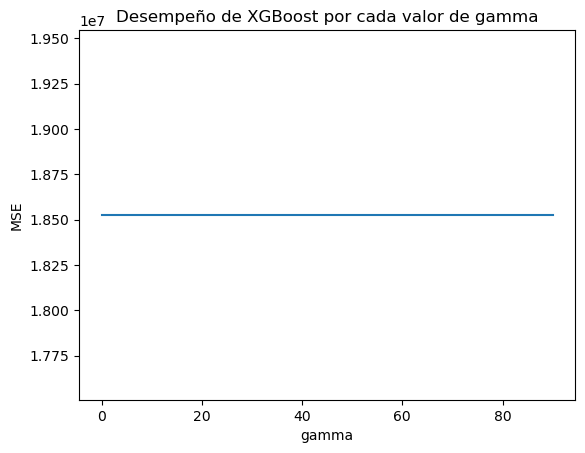

In [19]:
plt.plot(gamma, MSE_2)
plt.title("Desempeño de XGBoost por cada valor de gamma")
plt.xlabel('gamma')
plt.ylabel('MSE')

# Cargar predicciones en Kaggle

In [20]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 300000 entries, 34894 to 121958
Columns: 616 entries, Year to Model_xD5dr
dtypes: int64(616)
memory usage: 1.4 GB


In [21]:
X_train.columns

Index(['Year', 'Mileage', 'State_ AK', 'State_ AL', 'State_ AR', 'State_ AZ',
       'State_ CA', 'State_ CO', 'State_ CT', 'State_ DC',
       ...
       'Model_Yaris4dr', 'Model_YarisBase', 'Model_YarisLE', 'Model_Yukon',
       'Model_Yukon2WD', 'Model_Yukon4WD', 'Model_Yukon4dr', 'Model_tC2dr',
       'Model_xB5dr', 'Model_xD5dr'],
      dtype='object', length=616)

In [22]:
# Codificar variables categóricas en df_test
df_test_ = pd.get_dummies(df_test, columns=categorical_columns).astype(int)

# Alinear las columnas de df_test con X_train
df_test_aligned, _ = df_test_.align(X_train, axis=1, fill_value=0)

column_order = X_train.columns.tolist()

# Reordenar las columnas de df_test_aligned de acuerdo con el orden en X_train
df_test_ordenado = df_test_aligned[column_order]

In [23]:
df_test_ordenado.columns

Index(['Year', 'Mileage', 'State_ AK', 'State_ AL', 'State_ AR', 'State_ AZ',
       'State_ CA', 'State_ CO', 'State_ CT', 'State_ DC',
       ...
       'Model_Yaris4dr', 'Model_YarisBase', 'Model_YarisLE', 'Model_Yukon',
       'Model_Yukon2WD', 'Model_Yukon4WD', 'Model_Yukon4dr', 'Model_tC2dr',
       'Model_xB5dr', 'Model_xD5dr'],
      dtype='object', length=616)

In [25]:
# El modelo montado en Kaggle fue:
xgb_calibrado_3 = XGBRegressor(
    booster='gbtree',
    reg_lambda=0.30212357583678445,
    alpha=0.18211410327397226,
    subsample=0.3521449713976327,
    colsample_bytree=0.44811953613366806,
    max_depth=9,
    min_child_weight=9,
    eta=0.8918833748094722,
    gamma=0.00034064735565798957,
    grow_policy='lossguide',
    random_state=1  # Si deseas mantener una semilla aleatoria fija
)
xgb_calibrado_3.fit(X_train, y_train)
y_pred = xgb_calibrado_3.predict(X_test)
mse_xgb_calibrado_3 = mean_squared_error(y_test, y_pred)
mae_xgb_calibrado_3 = mean_absolute_error(y_test, y_pred)
rmse_xgb_calibrado_3 = np.sqrt(mse_xgb_calibrado_3)
print("El modelo XGB calibrado usando GreedSearch tiene un RMSE igual a " +str(rmse_xgb_calibrado_3)+ " y un MAE igual a "+str(mae_xgb_calibrado_3))

El modelo XGB calibrado usando GreedSearch tiene un RMSE igual a 3903.2092890134386 y un MAE igual a 2568.201309489746


In [26]:
# Se usa df_test_aligned para predecir
y_pred = xgb_cal.predict(df_test_ordenado)

predictions_df = pd.DataFrame(y_pred, index=df_test_ordenado.index, columns=['Price'])

predictions_df.to_csv('predicciones.csv')